In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import scipy.stats 

from collections import Counter

**Goal of this notebook**: Run some simulations with the goal of understanding what characteristics make it hard to ensure correct class-balanced coverage

## Setup

### Data generation procedure: Mixture of Gaussians

#### Phase I:
1. Randomly select a class $Y_i$ with probability determined by `P_Y`
2. Select the corresponding mean $\mu$ given by `means`
3. Sample $X_i \sim N(\mu, 1)$
4. Repeat steps 1-3 `num_samples` number of times

#### Phase II:
1. Compute $P(Y = k |X_i) = \frac{P(X_i | Y = k)P(Y_i = k)}{P(X_i)}$
2. Define score = $P(Y = \mathsf{truelabel} |X_i)$

In [2]:
def generate_synthetic_data(num_samples, means, std_dev, P_Y):
    '''
    Inputs:
        - num_samples: Number of samples to generate
        - means: array of the means of each Gaussian in the mixture of Gaussians 
        - std_dev: Scalar representing standard deviation of each Gaussian (all Gaussians have the same SD)
        - P_Y: array of same length as means. ith element is probability that true label is class i
    Outputs:
        - true_labels: num_samples length vector
        - class_probs: num_samples x 5 array containing P(Y_i = k | X_i) for each class k
    '''

    # --- Phase I ---
    # Generate mixture of Gaussians
    means = np.array(means) 
    std_devs = std_dev * np.ones((len(means),))
    P_Y = np.array(P_Y) 

    num_classes = len(means)

    # Select true labels randomly according to P_Y
    true_labels = np.random.choice(np.arange(num_classes), num_samples, p=P_Y)
    # Simulate values from corresponding Gaussians
    X = np.random.normal(loc=means[true_labels], scale=std_devs[true_labels], size=(num_samples,))
    
    # --- Phase II ---
    # Compute vector P(Y|X_i) for each X_i
    class_probs = np.zeros((num_samples, num_classes))
    for k in range(num_classes):
        P_X_given_Y = scipy.stats.norm(loc=means[k], scale=std_devs[k]).pdf(X)
        class_probs[:,k] = P_X_given_Y * P_Y[k] # P(Y and X_i)

    # Normalize each row to get P(Y and X_i) / P(X_i) = P(Y|X_i)
    class_probs = class_probs / np.expand_dims(np.sum(class_probs, axis=1), axis=1)
    
    return true_labels, class_probs


def compute_class_specific_quantiles(cal_true_labels, cal_class_probs, alpha=.05):
    num_samples = len(cal_true_labels)
    q_hats = np.zeros((cal_class_probs.shape[1],)) # q_hats[i] = quantile for class i
    for k in range(cal_class_probs.shape[1]):
        # Only select data for which k is true class
        idx = (cal_true_labels == k)
        scores = cal_class_probs[idx, k]
        scores = np.sort(scores)
        q_hats[k] = -np.quantile(-scores, np.ceil((num_samples+1)*(1-alpha))/num_samples)
       
    print('q_hats', q_hats)
    return q_hats

# Create class_balanced prediction sets
def create_cb_prediction_sets(class_probs, q_hats):
    '''
    Inputs:
        - class_probs: as ouput by generate_synthetic_data
        - q_hats: as output by compute_class_specific_quantiles
    '''
    set_preds = []
    num_samples = len(class_probs)
    for i in range(num_samples):
        set_preds.append(np.where(class_probs[i,:] >= q_hats)[0])
        
    return set_preds

# Helper function for computing accuracy (marginal coverage) of confidence sets
def compute_coverage(true_labels, set_preds):
    num_correct = 0
    for true_label, preds in zip(true_labels, set_preds):
        if true_label in preds:
            num_correct += 1
    set_pred_acc = num_correct / len(true_labels)
    
    return set_pred_acc

# Helper function for computing class-specific coverage of confidence sets
def compute_class_specific_coverage(true_labels, set_preds):
    num_classes = max(true_labels) + 1
    class_specific_cov = np.zeros((num_classes,))
    for k in range(num_classes):
        idx = np.where(true_labels == k)[0]
        selected_preds = [set_preds[i] for i in idx]
        num_correct = np.sum([1 if np.any(pred_set == k) else 0 for pred_set in selected_preds])
        class_specific_cov[k] = num_correct / len(selected_preds)
        
    return class_specific_cov

# Experiment 1: What is the effect of increasing class similarity?
We model class similarity by increasing the standard deviation of the Gaussians in our mixture (this increases overlap between distributions)
[Note: another knob we could turn is the distance between the means of the Gaussian distribution]

In [3]:
calibration_data_size = 1000 
test_data_size = 10000
num_trials = 5 # Number of synthetic datasets to generate for each parameter setting

In [4]:
# np.set_printoptions(suppress=True) # Suppress scientific notation when printing arrays
# np.set_printoptions(suppress=False)

# Specify standard deviations to use
std_devs = [0.1, 0.5, 1, 3, 5, 10]
# std_devs = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5, 1, 3, 5, 10]

# Fixed settings (held constant throughout experiment)
alpha = .05 # Specifies coverage level 
means = [1, 2, 3, 4, 5, 6] # Means of Gaussians in mixture
num_classes = len(means)
P_Y = np.ones((num_classes,)) / num_classes # Uniform class balance

# Run experiment
test_coverage = np.zeros((len(std_devs), num_trials, num_classes))
for i, std_dev in enumerate(std_devs):
    print('std_dev:', std_dev)
    for j in range(num_trials):
        # Generate datasets with desired level of class similarity
        cal_true_labels, cal_class_probs = generate_synthetic_data(calibration_data_size, means, std_dev, P_Y)
        test_true_labels, test_class_probs = generate_synthetic_data(calibration_data_size, means, std_dev, P_Y)
        
        print('cal_class_probs', cal_class_probs[:3,:])

        # Compute class-specific score quantiles
        q_hats = compute_class_specific_quantiles(cal_true_labels, cal_class_probs, alpha=.05)

        # Create prediction sets for test set
        set_preds = create_cb_prediction_sets(test_class_probs, q_hats)
        avg_set_size = np.mean([len(x) for x in set_preds])
        print(f'Average set size {avg_set_size:.2f}')

        # [Could also compute marginal coverage here]
        
        # Compute class-specific coverage for test set
        class_specific_cov = compute_class_specific_coverage(test_true_labels, set_preds)
        test_coverage[i,j,:] = class_specific_cov
    print()

std_dev: 0.1
cal_class_probs [[1.00000000e+000 3.35477744e-030 4.18677130e-103 1.94377759e-219
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.32658839e-205 1.29056803e-093
  1.86257833e-025 1.00000000e+000]
 [0.00000000e+000 3.61535428e-195 6.33211458e-087 4.12570791e-022
  1.00000000e+000 9.01681859e-023]]
q_hats [1. 1. 1. 1. 1. 1.]
Average set size 0.95
cal_class_probs [[0.00000000e+000 7.53533730e-307 3.56450566e-165 6.27260196e-067
  4.10627433e-012 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00338167e-201 2.69417396e-091
  2.69114384e-024 1.00000000e+000]
 [4.49125048e-028 1.00000000e+000 8.28294033e-017 2.55223626e-076
  2.92556012e-179 0.00000000e+000]]
q_hats [1. 1. 1. 1. 1. 1.]
Average set size 0.93
cal_class_probs [[2.91964979e-093 2.80149257e-025 1.00000000e+000 1.32789071e-019
  6.55958671e-082 1.20543121e-187]
 [0.00000000e+000 0.00000000e+000 1.11207997e-195 2.88539674e-087
  2.78501067e-022 1.00000000e+000]
 [8.93638528e-220 2.49395979e-1

cal_class_probs [[0.29625442 0.23554294 0.17993    0.13205817 0.09312262 0.06309186]
 [0.16864614 0.17685494 0.17819118 0.17249774 0.1604386  0.1433714 ]
 [0.13978311 0.15795303 0.1714863  0.1788789  0.17927388 0.17262479]]
q_hats [0.07194504 0.08959294 0.13586256 0.13190349 0.11637473 0.08839142]
Average set size 5.33
cal_class_probs [[0.19114907 0.18998297 0.1814201  0.1664502  0.14672749 0.12427016]
 [0.2672654  0.22536549 0.18258299 0.14212204 0.1062896  0.07637449]
 [0.12847656 0.14985067 0.16792744 0.18080602 0.18703906 0.18590025]]
q_hats [0.07308958 0.08930497 0.13074779 0.13863607 0.09226517 0.09300072]
Average set size 5.42

std_dev: 10
cal_class_probs [[0.10613043 0.1269721  0.15039513 0.17636657 0.20476505 0.23537073]
 [0.12861355 0.14386936 0.15933344 0.17470391 0.18965111 0.20382863]
 [0.14225561 0.15332154 0.16360403 0.17283905 0.18077851 0.18720126]]
q_hats [0.1163363  0.13220156 0.15014607 0.14901841 0.12708937 0.11537116]
Average set size 5.59
cal_class_probs [[0.2219

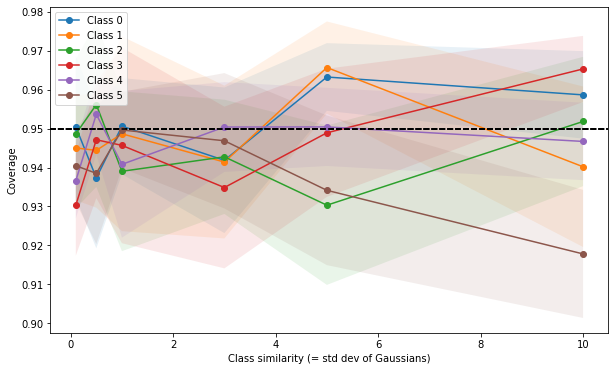

In [5]:
# Plot results

fig, ax = plt.subplots(figsize=(10,6))
x = std_devs
for k in range(num_classes):
    y = test_coverage[:,:,k]
    y_mean = np.mean(y, axis=1)
    ci = 1.96 * np.std(y, axis=1)/np.sqrt(len(x))   
    ax.plot(x,y_mean, label=f'Class {k}', marker='o')
    ax.fill_between(x, (y_mean-ci), (y_mean+ci), alpha=.1)
    ax.axhline(y=1-alpha, color='black', linestyle='--')
    ax.set_xlabel('Class similarity (= std dev of Gaussians)')
    ax.set_ylabel('Coverage')
    ax.legend()
#     ax.set_xlim(0, .1)

# Experiment 2: What is the effect of increasing class imbalance?

We specify the class balance by letting `P_Y` be a convex combination of the uniform distribution and the distribution [1, 0, 0, ...].

In [59]:
calibration_data_size = 1000000
test_data_size = 10000
num_trials = 5 # Number of synthetic datasets to generate for each parameter setting

In [60]:
# Specify weighting factor 'a' for talking convex combination of uniform and unbalanced class distributions
# Larger a corresponds to more imbalance
imbalances = [0, .1, .5, .9, .95, .99, .995]

# Fixed settings (held constant throughout experiment)
alpha = .05 # Specifies coverage level 
means = [1, 2, 3, 4, 5, 6] # Means of Gaussians in mixture
std_dev = 2
num_classes = len(means)

uniform = np.ones((num_classes,)) / num_classes
unbalanced = np.zeros((num_classes,))
unbalanced[0] = 1

# Run experiment
test_coverage2 = np.zeros((len(imbalances), num_trials, num_classes))
for i, a in enumerate(imbalances):
    print('Imbalance level:', a)
    for j in range(num_trials):
        
        # Generate datasets with desired class imbalance
        P_Y = (1-a) * uniform + a * unbalanced  
        print(P_Y)
        cal_true_labels, cal_class_probs = generate_synthetic_data(calibration_data_size, means, std_dev, P_Y)
        print('Number of instances of each class:', sorted(Counter(cal_true_labels).items()))
        test_true_labels, test_class_probs = generate_synthetic_data(calibration_data_size, means, std_dev, P_Y)

        # Compute class-specific score quantiles
        q_hats = compute_class_specific_quantiles(cal_true_labels, cal_class_probs, alpha=.05)

        # Create prediction sets for test set
        set_preds = create_cb_prediction_sets(test_class_probs, q_hats)
        avg_set_size = np.mean([len(x) for x in set_preds])
        print(f'Average set size {avg_set_size:.2f}')

        # [Could also compute marginal coverage here]
        
        # Compute class-specific coverage for test set
        class_specific_cov = compute_class_specific_coverage(test_true_labels, set_preds)
        test_coverage2[i,j,:] = class_specific_cov
    print()

Imbalance level: 0
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Number of instances of each class: [(0, 166720), (1, 167282), (2, 166174), (3, 167522), (4, 166446), (5, 165856)]
q_hats [0.06053576 0.07159344 0.08904367 0.08913893 0.07108974 0.06091525]
Average set size 4.41
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Number of instances of each class: [(0, 166130), (1, 166581), (2, 166522), (3, 167226), (4, 166322), (5, 167219)]
q_hats [0.06195141 0.07140161 0.08831688 0.08838374 0.07078143 0.06068001]
Average set size 4.41
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Number of instances of each class: [(0, 166456), (1, 166887), (2, 166939), (3, 166723), (4, 166443), (5, 166552)]
q_hats [0.06150653 0.07136429 0.08824474 0.08863026 0.0716803  0.06187856]
Average set size 4.41
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Number of instances of each class: [(0, 166859), (1, 166852), (2, 165804), (

Average set size 3.64

Imbalance level: 0.995
[9.95833333e-01 8.33333333e-04 8.33333333e-04 8.33333333e-04
 8.33333333e-04 8.33333333e-04]
Number of instances of each class: [(0, 995864), (1, 834), (2, 801), (3, 842), (4, 864), (5, 795)]
q_hats [9.87431544e-01 4.23989643e-04 2.71253824e-04 1.79434422e-04
 2.22769103e-04 3.76544876e-04]
Average set size 3.71
[9.95833333e-01 8.33333333e-04 8.33333333e-04 8.33333333e-04
 8.33333333e-04 8.33333333e-04]
Number of instances of each class: [(0, 995856), (1, 834), (2, 840), (3, 808), (4, 853), (5, 809)]
q_hats [9.87391392e-01 4.21624182e-04 2.62399182e-04 2.26157931e-04
 2.38737761e-04 3.85172052e-04]
Average set size 3.65
[9.95833333e-01 8.33333333e-04 8.33333333e-04 8.33333333e-04
 8.33333333e-04 8.33333333e-04]
Number of instances of each class: [(0, 995953), (1, 834), (2, 817), (3, 816), (4, 797), (5, 783)]
q_hats [9.87344714e-01 4.33508300e-04 2.57964577e-04 2.63922558e-04
 2.53896958e-04 2.61563197e-04]
Average set size 3.63
[9.95833333e

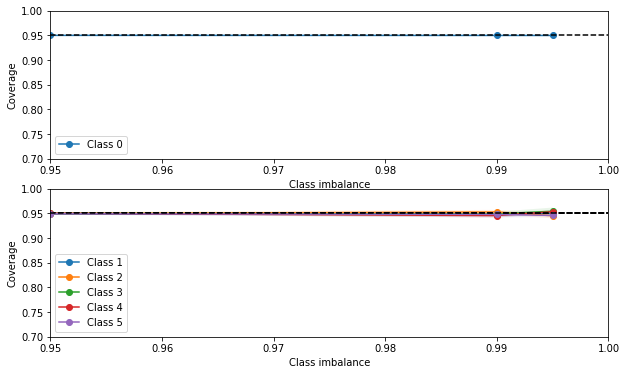

In [61]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))
for k in range(num_classes):
    x = imbalances
    y = test_coverage2[:,:,k]
    y_mean = np.mean(y, axis=1)
    ci = 1.96 * np.std(y, axis=1)/np.sqrt(len(x))
    
    # Plot Class 0 separately
    if k == 0:
        ax = axs[0]
    else:
        ax = axs[1]
        
    ax.plot(x,y_mean, label=f'Class {k}', marker='o')
    ax.fill_between(x, (y_mean-ci), (y_mean+ci), alpha=.1)
    ax.axhline(y=1-alpha, color='black', linestyle='--')
    ax.legend(loc='lower left')
    ax.set_xlabel('Class imbalance')
    ax.set_ylabel('Coverage')
    ax.set_ylim(.7, 1)
    plt.savefig(f'figs/class_imbalance_numcal={calibration_data_size}_coverage')
    ax.set_xlim(.95, 1)
    plt.savefig(f'figs/class_imbalance_numcal={calibration_data_size}_coverage_ZOOMEDIN')

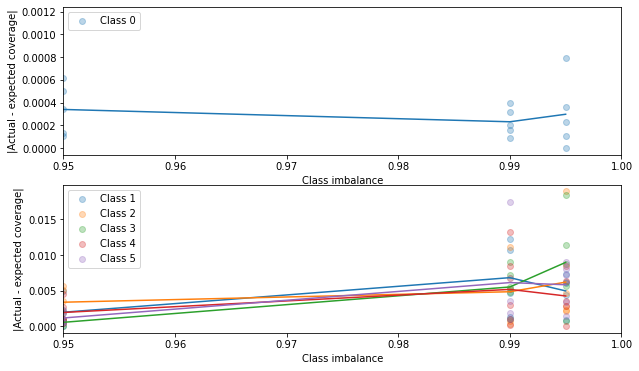

In [62]:
# Plot average coverage gap = deviation from desired coverage level (0.95)
fig, axs = plt.subplots(2, 1, figsize=(10,6))
for k in range(num_classes):
    x = imbalances
    y = test_coverage2[:,:,k]
    diff = abs(y - (1-alpha))
    avg_diff = np.mean(diff, axis=1)
#     y_mean = np.mean(y, axis=1)
#     ci = 1.96 * np.std(y, axis=1)/np.sqrt(len(x))
    
    # Plot Class 0 separately
    if k == 0:
        ax = axs[0]
    else:
        ax = axs[1]
        
    ax.plot(x, avg_diff)
    ax.scatter(np.tile(x, (num_trials,1)).T, diff, label=f'Class {k}', marker='o', alpha=0.3)
    ax.legend(loc='upper left')
    ax.set_xlabel('Class imbalance')
    ax.set_ylabel('|Actual - expected coverage|')
#     ax.set_ylim(0, 0.35)
#     ax.set_xlim(.95, 1)
    plt.savefig(f'figs/class_imbalance_numcal={calibration_data_size}_coverage_gap')
    ax.set_xlim(.95, 1)
    plt.savefig(f'figs/class_imbalance_numcal={calibration_data_size}_coverage_gap_ZOOMEDIN')